In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import urbangrammar_graphics as ugg
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from clustergram import Clustergram
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
def list_tabels(conn):
    cursorObj = conn.cursor()
    cursorObj.execute('SELECT name FROM sqlite_master WHERE type = "table"')
    print(cursorObj.fetchall())

def fetch_data(conn, tableName):
    query = '''SELECT * FROM {}'''.format(tableName)
    df = pd.read_sql_query(query, conn)
    return df

def fetch_metadata(conn):
    metadata = pd.read_sql_query('SELECT * FROM MetaBioinfoexperiment', conn)
    metadata = metadata[metadata['study_type'] == 'RNA-Seq']
    metadata = metadata[metadata['category'] != None]
    return metadata

def close_connection(conn):
    conn.close()
    
def transform(df):
    bioinfoexp_ids = df['bioinfoexperiment_id'].unique()
    df_list = []
    for index in range(len(bioinfoexp_ids)):
        bioinfoexp_id = bioinfoexp_ids[index]
        tmp_df = df[df['bioinfoexperiment_id'] == bioinfoexp_id]
        tmp_df.drop(columns = ['bioinfoexperiment_id'], inplace = True)
        tmp_df = tmp_df.set_index('gene_id')
        tmp_df.index.name = None
        tmp_df.rename(columns = {'count' : bioinfoexp_id}, inplace = True)
        df_list.append(tmp_df.T)
    final_df = pd.concat(df_list)
    return final_df

In [3]:
# create a connection to the database
conn = sqlite3.connect('/src/Data/MockGMU_20.db')

# fetch the rna counts data
sql_df = fetch_data(conn, "RNA_GeneCounts")

# select valid sample ids
query = '''SELECT bioinfoexperiment_id FROM MetaBioinfoexperiment
           WHERE study_type = 'RNA-Seq' '''
valid_samples = pd.read_sql_query(query, conn)
valid_samples = list(valid_samples['bioinfoexperiment_id'])

# filter out those valide samples
sql_df = sql_df.query('bioinfoexperiment_id in @valid_samples')

# reform the dataframe
df = transform(sql_df)
df.reset_index(inplace = True)
df = df.rename(columns = {'index': 'bioinfoexperiment_id'})

# fetch the metadata from the study design file
metadata = fetch_metadata(conn)
metadata = metadata[['bioinfoexperiment_id', 'category']]
metadata.rename(columns = {'category' : 'Tissue_Type'}, inplace = True)
metadata.replace(to_replace = 'Tu', value = 'T1', inplace = True)
metadata.replace(to_replace = 'AN', value = 'T2', inplace = True)
metadata.replace(to_replace = 'DN', value = 'T3', inplace = True)

# merge the dataframe and the metadata
df = pd.merge(df, metadata, on = 'bioinfoexperiment_id')
df.set_index('bioinfoexperiment_id', inplace = True)

/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors

In [4]:
sns.set(style = 'whitegrid')
cgram = Clustergram(range(1, len(df)), n_init = 1000)
cgram.fit(df.iloc[ : , 0 : df.shape[1] - 1])

K=1 skipped. Mean computed from data directly.
K=2 fitted in 2.2637739181518555 seconds.
K=3 fitted in 3.3175437450408936 seconds.
K=4 fitted in 4.502434730529785 seconds.
K=5 fitted in 5.709414958953857 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

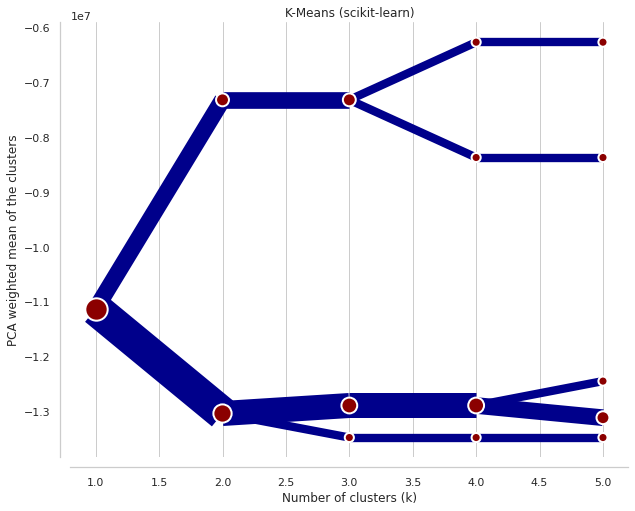

In [5]:
ax = cgram.plot(figsize = (10, 8), 
                line_style = dict(color = 'darkblue'),
                cluster_style = {'color': 'darkred'},
               )
ax.yaxis.grid(False)
sns.despine(offset = 10)
ax.set_title('K-Means (scikit-learn)')

For n_clusters = 2 The average silhouette_score is : 0.6363223424806589
For n_clusters = 3 The average silhouette_score is : 0.40131282210169744
For n_clusters = 4 The average silhouette_score is : 0.23079883657497016
For n_clusters = 5 The average silhouette_score is : 0.0820771962673306


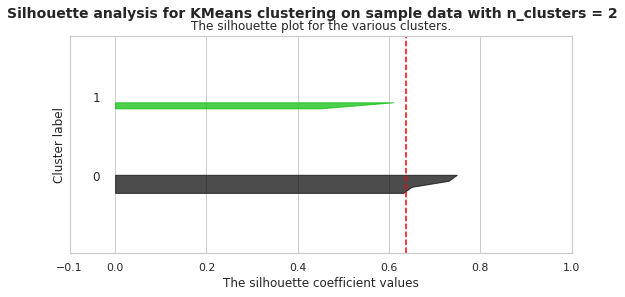

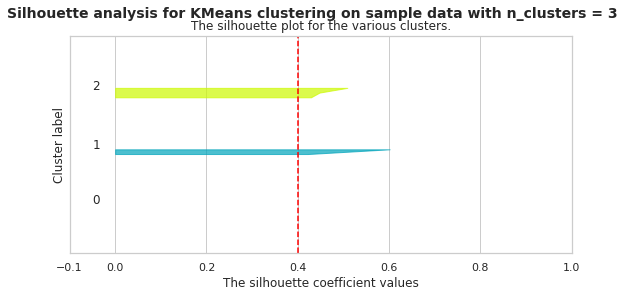

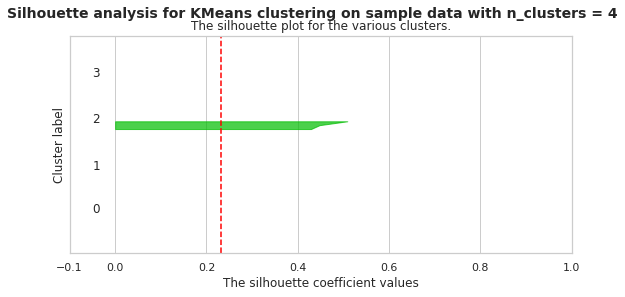

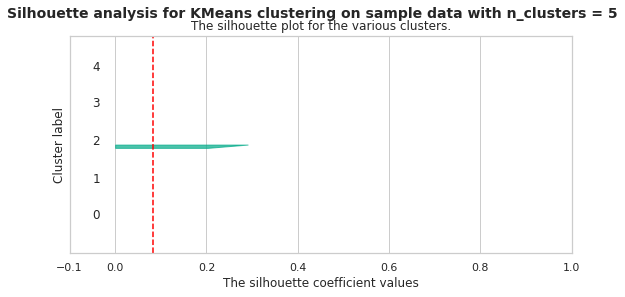

In [6]:
range_n_clusters = range(2, len(df))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(df.iloc[ : , 0 : df.shape[1] - 1])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df.iloc[ : , 0 : df.shape[1] - 1], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df.iloc[ : , 0 : df.shape[1] - 1], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x = silhouette_avg, color = "red", linestyle = "--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize = 14, fontweight = 'bold')

plt.show()

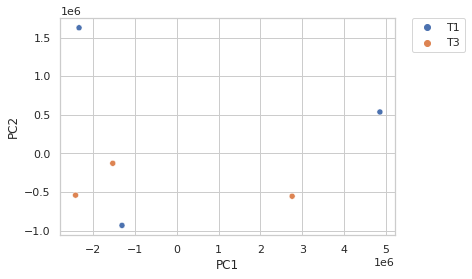

In [7]:
pca = PCA(2)
pca_df = pca.fit_transform(df.iloc[ : , 0 : df.shape[1] - 1])
pca_df = pd.DataFrame(pca_df, columns = ['PC1', 'PC2'])
pca_df['Tissue_Type'] = df['Tissue_Type'].values
sns.scatterplot(data = pca_df, x = 'PC1', y = 'PC2', hue = 'Tissue_Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


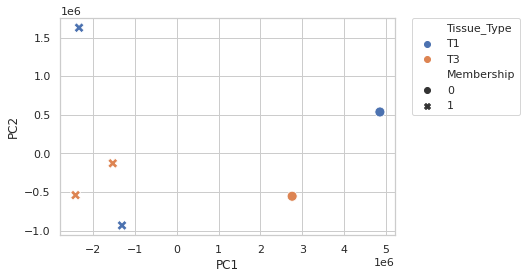

In [8]:
k = 2
kmeans = KMeans(n_clusters = k)
label = kmeans.fit_predict(pca_df.iloc[ : , 0 : 2])

filtered_label0 = pca_df[label == 0]
filtered_label1 = pca_df[label == 1]

filtered_label0['Membership'] = 0
filtered_label1['Membership'] = 1

filtered_label = pd.concat([filtered_label0, filtered_label1])
sns.scatterplot(data = filtered_label, x = 'PC1', y = 'PC2', hue = 'Tissue_Type', style = 'Membership', s = 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

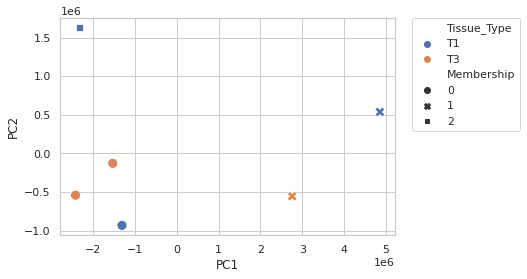

In [9]:
k = 3
kmeans = KMeans(n_clusters = k)
label = kmeans.fit_predict(pca_df.iloc[ : , 0 : 2])

filtered_label0 = pca_df[label == 0]
filtered_label1 = pca_df[label == 1]
filtered_label2 = pca_df[label == 2]

filtered_label0['Membership'] = 0
filtered_label1['Membership'] = 1
filtered_label2['Membership'] = 2

filtered_label = pd.concat([filtered_label0, filtered_label1, filtered_label2])
sns.scatterplot(data = filtered_label, x = 'PC1', y = 'PC2', hue = 'Tissue_Type', style = 'Membership', s = 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
# fetch the normalized read counts
norm_df = fetch_data(conn, 'Normalized_Counts')

# take out the shortnames of the valid samples
valid_samples = pd.read_sql_query('''SELECT shortname FROM StudyDesign
                                     WHERE shortname IS NOT NULL
                                     AND shortname != '' ''', conn)
valid_samples = list(valid_samples['shortname'])
norm_df = norm_df.set_index('gene')

# filter out the valide samples
norm_df = norm_df[valid_samples]
norm_df = norm_df.T

close_connection(conn)

norm_df['Tissue_Type'] = df['Tissue_Type'].values

In [12]:
cgram = Clustergram(range(1, len(norm_df)), n_init = 1000)
cgram.fit(norm_df.iloc[ : , 0 : norm_df.shape[1] - 1])

K=1 skipped. Mean computed from data directly.
K=2 fitted in 1.7221310138702393 seconds.
K=3 fitted in 2.3939826488494873 seconds.
K=4 fitted in 3.146516799926758 seconds.
K=5 fitted in 4.064926385879517 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

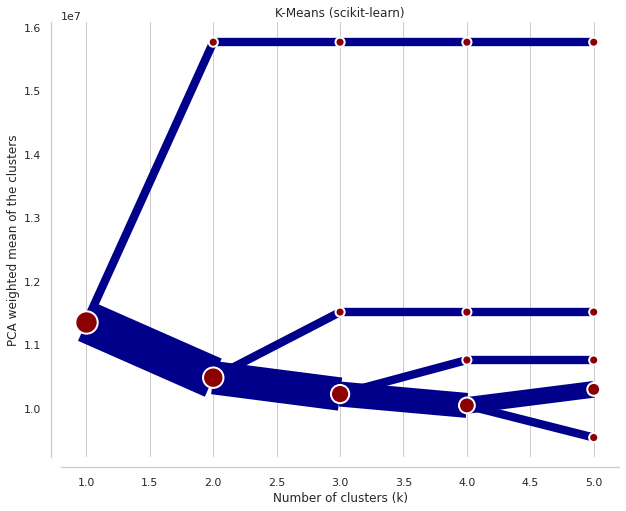

In [13]:
ax = cgram.plot(figsize = (10, 8), 
                line_style = dict(color = 'darkblue'),
                cluster_style = {'color': 'darkred'},
               )
ax.yaxis.grid(False)
sns.despine(offset = 10)
ax.set_title('K-Means (scikit-learn)')

For n_clusters = 2 The average silhouette_score is : 0.5071532181254849
For n_clusters = 3 The average silhouette_score is : 0.4623324766911378
For n_clusters = 4 The average silhouette_score is : 0.18903328670586292
For n_clusters = 5 The average silhouette_score is : 0.21570936950898534


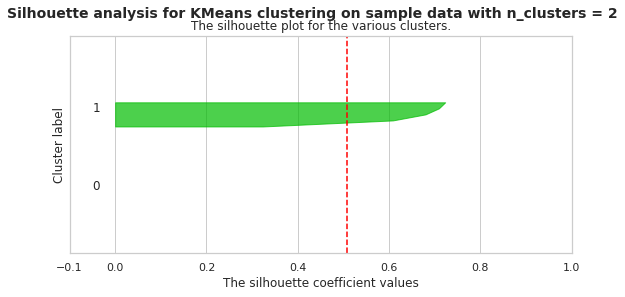

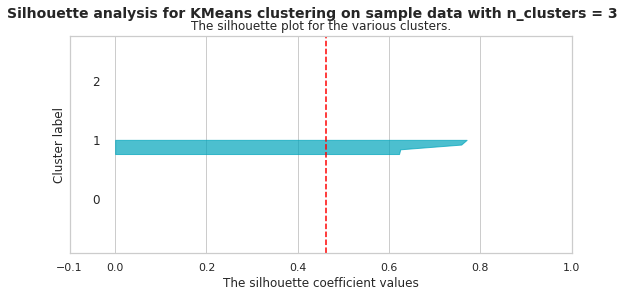

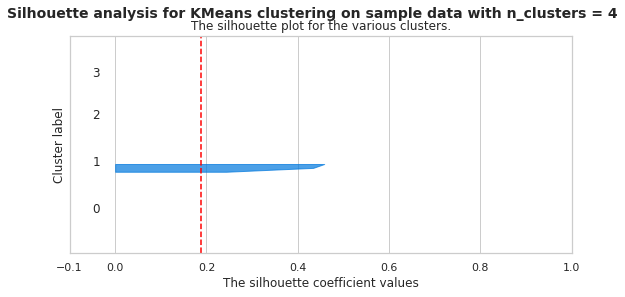

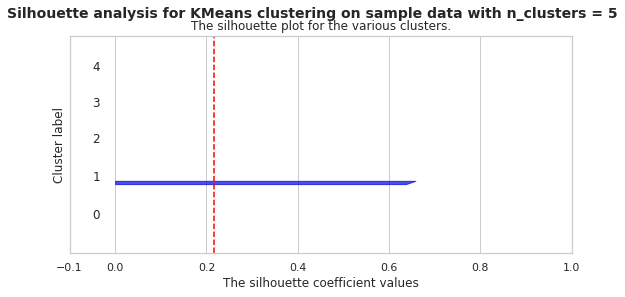

In [14]:
range_n_clusters = range(2, len(norm_df))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(norm_df.iloc[ : , 0 : norm_df.shape[1] - 1])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(norm_df.iloc[ : , 0 : norm_df.shape[1] - 1], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(norm_df.iloc[ : , 0 : norm_df.shape[1] - 1], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x = silhouette_avg, color = "red", linestyle = "--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize = 14, fontweight = 'bold')

plt.show()

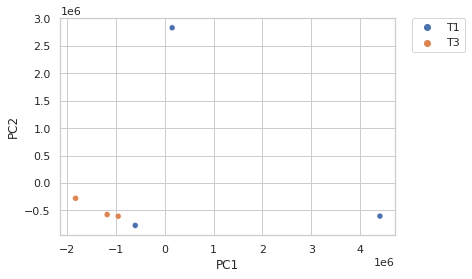

In [15]:
pca = PCA(2)
pca_df = pca.fit_transform(norm_df.iloc[ : , 0 : norm_df.shape[1] - 1])
pca_df = pd.DataFrame(pca_df, columns = ['PC1', 'PC2'])
pca_df['Tissue_Type'] = norm_df['Tissue_Type'].values
sns.scatterplot(data = pca_df, x = 'PC1', y = 'PC2', hue = 'Tissue_Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


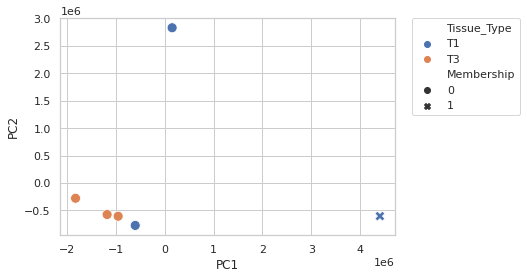

In [16]:
k = 2
kmeans = KMeans(n_clusters = k)
label = kmeans.fit_predict(pca_df.iloc[ : , 0 : 2])

filtered_label0 = pca_df[label == 0]
filtered_label1 = pca_df[label == 1]

filtered_label0['Membership'] = 0
filtered_label1['Membership'] = 1

filtered_label = pd.concat([filtered_label0, filtered_label1])
sns.scatterplot(data = filtered_label, x = 'PC1', y = 'PC2', hue = 'Tissue_Type', style = 'Membership', s = 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/mali/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

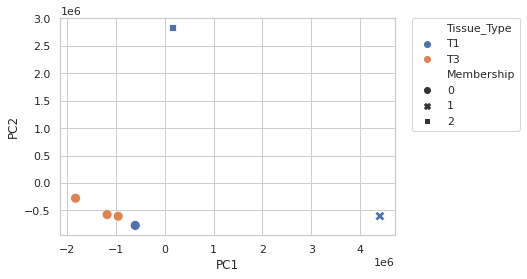

In [17]:
k = 3
kmeans = KMeans(n_clusters = k)
label = kmeans.fit_predict(pca_df.iloc[ : , 0 : 2])

filtered_label0 = pca_df[label == 0]
filtered_label1 = pca_df[label == 1]
filtered_label2 = pca_df[label == 2]

filtered_label0['Membership'] = 0
filtered_label1['Membership'] = 1
filtered_label2['Membership'] = 2

filtered_label = pd.concat([filtered_label0, filtered_label1, filtered_label2])
sns.scatterplot(data = filtered_label, x = 'PC1', y = 'PC2', hue = 'Tissue_Type', style = 'Membership', s = 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)